Consider the data set you have received in your e-mail, which is of the form (t,y(t)). Try
to fit the following model to the given data set:
y(t) = α1 + α2eβt + (t).
Let us assume that {(t)}is a sequence of i.i.d. normal random variable with mean zero and
finite variance. Analyze the data keeping the following points in mind, and write a report
based on that.
1. Plot the data.
2. Plot the residual sum of squares as a function of β.
3. Find the least squares estimators of α1, α2 and β based on the Gauss-Newton method.
Clearly mention which initial value you are taking? Does your result affect by the
choice of the initial guess?
4. Find the estimate of σ2.
5. Find the associated confidence intervals based on the Fisher information matrix.
6. Plot the residuals.
7. Test whether it satisfies the normality assumption or not?
8. Use any standard package (say R) and try to obtain the least squares estimators of
the unknown parameters based on three dimensional optimization problem. Repeat
all the above questions. Indicate which initial values you are taking and why?
9. What will you do to fit the following model
y(t) = α1eβ1t + α2eβ2t + (t),
to the same data set? Let us assume that (t) satisfies the same assumption as above.
1

### setup

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
import matplotlib.pyplot as plt

/home/sunild/anaconda3/lib/python3.8/site-packages/patsy/constraint.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import Mapping
/home/sunild/anaconda3/lib/python3.8/site-packages/matplotlib_inline/config.py:66: DeprecationWarning: InlineBackend._figure_formats_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_formats_changed(self, name, old, new):


In [2]:

data=pd.read_csv('data-39.txt',header=None,sep=r'\s+')
# use regex expressions

In [3]:
x=data.iloc[:,0]
y=data.iloc[:,1]

In [4]:
data.head()

,0,1
0,0.02,2.3031
1,0.03,2.3992
2,0.05,2.3923
3,0.06,2.4571
4,0.08,2.3859


### 1

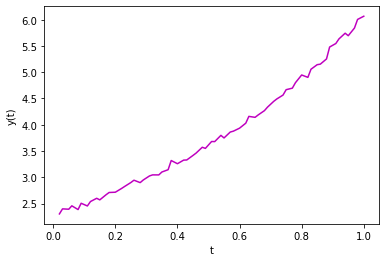

In [5]:
plt.plot(x,y,c='m')
plt.xlabel('t')
plt.ylabel('y(t)')
plt.show()

### 2

In [6]:
'''how one chooses which beta points to consider'''
beta_points=np.linspace(25,36.1,100) 
sse_points=[]
for beta_fixed in beta_points:
    x_fixed=np.exp(beta_fixed*x)
    y_fixed=y
    tmp_data=pd.DataFrame({'t':x_fixed,'y_t':y_fixed})
    model=smf.ols('y_t ~ t',tmp_data).fit()
    sse_value=sum((model.fittedvalues-np.mean(tmp_data['y_t']))**2)
    sse_points.append(sse_value)

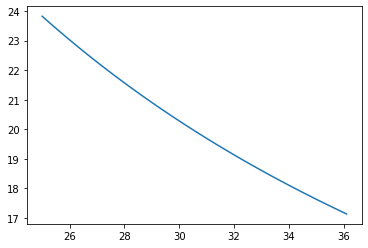

In [7]:
plt.plot(beta_points,sse_points)
plt.show()

### 3

In [69]:
def gauss_newton(start_theta,n_iter=100):
    curr_theta=start_theta
    thetas_values=[curr_theta]
    for i in range(n_iter):
        # print(i)
        curr_alpha1=curr_theta[0]
        curr_alpha2=curr_theta[1]
        curr_beta=curr_theta[2]

        e_beta1=sum(np.exp(curr_beta*x))
        e_beta2=sum(np.exp(2*curr_beta*x))
        
        C_matrix=np.array([
            [len(x),e_beta1,curr_beta*curr_alpha2*e_beta1],
            [e_beta1,e_beta2,curr_beta*curr_alpha2*e_beta2],
            [curr_beta*curr_alpha2*e_beta1,curr_beta*curr_alpha2*e_beta2,(curr_beta**2)*(curr_alpha2**2)*e_beta2]
        ])
        F_matrix=np.array([
            [1]*len(x),
            np.exp(curr_beta*x),
            curr_beta*curr_alpha2*np.exp(curr_beta*x)
        ])
        curr_theta=curr_theta+np.dot(np.dot(np.linalg.inv(C_matrix),F_matrix),np.array(y-(curr_alpha1+curr_alpha2*np.exp(curr_beta*x))))
        thetas_values.append(curr_theta)
    return thetas_values

In [81]:
theta_estimate=gauss_newton(np.array([3,0.2,2.5]))[-1]

array([1.26089127, 1.09654455, 1.48974118])

TODO: Solve singualr matrix issue with a good start value

- it is very sensetive to the starting value of theta
- how do we get good starting value for this method
    - might use linear algebra estimated values; or might use values that are near to linear-model fitted values
- theoratically we should converge if we have good start and give algo enough time to run 

### 4

$$\hat{\sigma^2}=\frac{1}{n-p}(y-f(\hat{\theta}))^T(y-f(\hat{\theta})) $$
Here $p=3$

### 5

$$\sqrt{n}(\hat{\Theta}-\Theta) \sim \mathcal{N}_{p+1}(0,I^{-1})$$
Here $I^{-1}$ is inverse of fisher information matrix. $p=3$ and $\Theta=(\theta,\sigma^2)$